In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def normalizer(x):
    m = x.shape[0]
    x = x - np.mean(x)
    x = (x * m) / (np.sum(x ** 2))
    # x = x - np.mean(x)
    # x = x / np.sqrt(np.sum(x**2) / len(x) - 1)
    return x

In [2]:
train = pd.read_csv("./datasets/train.csv")

## <font color=blue>1. Analyzing features</font> 

### Observing pclass 
Pclass 2 is obviously insignificant <br>
Pclass 1 possibly doesn't help 

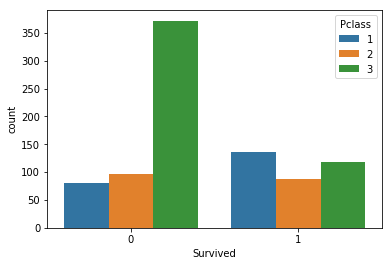

In [3]:
sns.countplot(x='Survived',hue='Pclass',data=train)
plt.show()

### Observing Embarked 
 

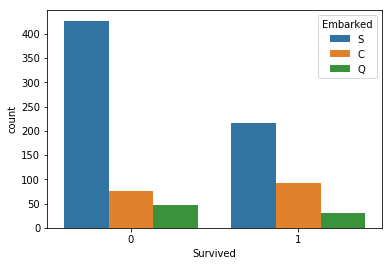

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


In [4]:

sns.countplot(x='Survived',hue='Embarked',data=train)
plt.show()
print(train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False))
# C and Q should be tested

### Observing Sex
it is very important

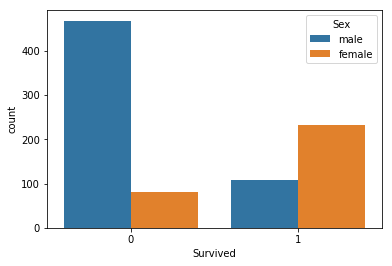

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [5]:
sns.countplot(x='Survived',hue='Sex',data=train)
plt.show()
print(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))

### Observing Name

In [6]:
name = train.Name
name = name.map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
name = name.replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
name = name.replace(['Mme', 'Mrs', 'Mlle', 'Ms', 'Miss'], 'Female')
name = pd.get_dummies(name, drop_first=False)
name.head()

,Female,Master,Mr,Rare
0,0,0,1,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


Master in not helpful

In [7]:
tmp = pd.concat([train['Survived'],name], axis=1)
print(tmp[['Rare','Mr','Master','Female','Survived']].groupby(['Rare','Mr','Female','Master'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Rare  Mr  Female  Master  Survived
1     0   0       1       0  0.739550
0     0   0       0       1  0.575000
3     1   0       0       0  0.347826
2     0   1       0       0  0.156673


### Observing Ticket

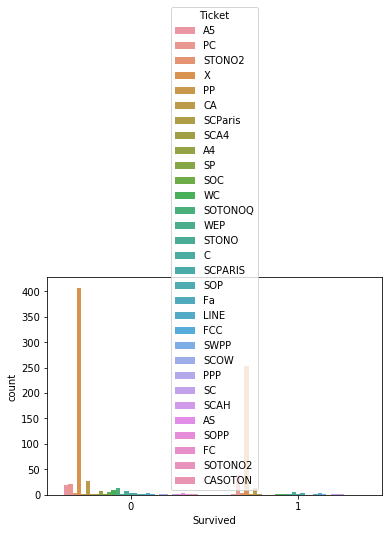

     Ticket  Survived
27     SWPP  1.000000
13       SC  1.000000
7       FCC  0.800000
15     SCAH  0.666667
11       PP  0.666667
10       PC  0.650000
12      PPP  0.500000
26   STONO2  0.500000
18  SCParis  0.500000
17  SCPARIS  0.428571
25    STONO  0.416667
3         C  0.400000
30        X  0.384266
4        CA  0.341463
29      WEP  0.333333
9      LINE  0.250000
19      SOC  0.166667
23  SOTONOQ  0.133333
28       WC  0.100000
1        A5  0.095238
2        AS  0.000000
5   CASOTON  0.000000
24       SP  0.000000
22  SOTONO2  0.000000
14     SCA4  0.000000
21     SOPP  0.000000
20      SOP  0.000000
6        FC  0.000000
8        Fa  0.000000
16     SCOW  0.000000
0        A4  0.000000


In [8]:
ticket = train.Ticket
def ticket_handler(ticket):
        ticket = ticket.replace( '.' , '' )
        ticket = ticket.replace( '/' , '' )
        ticket = ticket.split()
        ticket = map( lambda t : t.strip() , ticket )
        ticket = list(filter( lambda t : not t.isdigit() , ticket ))
        if len( ticket ) > 0:
            return (ticket[0])
        else: 
            return 'X'
        
ticket = ticket.map( ticket_handler )
tmp = pd.concat([train['Survived'],ticket], axis=1)
sns.countplot(x='Survived',hue='Ticket',data=tmp)
plt.show()
print(tmp[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean().sort_values(by='Survived', ascending=False))

### Observing Cabin

use only E,B,D,W if they have significant impact

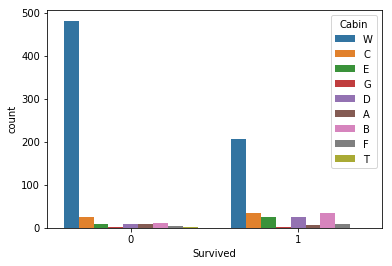

  Cabin  Survived
3     D  0.757576
4     E  0.750000
1     B  0.744681
5     F  0.615385
2     C  0.593220
6     G  0.500000
0     A  0.466667
8     W  0.299854
7     T  0.000000


In [9]:
 cabin = train.Cabin
cabin = cabin.fillna( 'Without Cabin' )
cabin = cabin.map( lambda c : c[0] )
tmp = pd.concat([train['Survived'],cabin], axis=1)
sns.countplot(x='Survived',hue='Cabin',data=tmp)
plt.show()
print(tmp[['Cabin', 'Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False))



### Observing family features

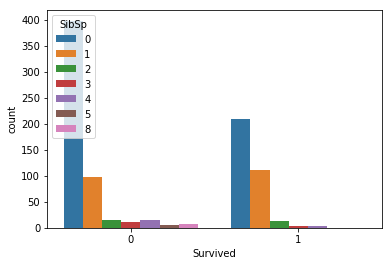

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


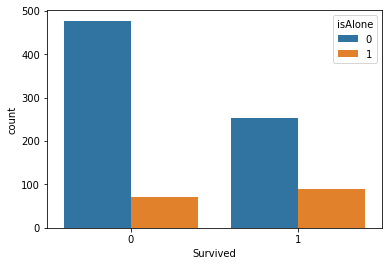

   isAlone  Survived
1        1  0.552795
0        0  0.346575


In [10]:
siblings = train.SibSp
parents = train.Parch
size = siblings + parents
train['isAlone'] = size.map( lambda s : 1 if s == 1 else 0 )
tmp = pd.concat([train['Survived'],siblings], axis=1)
sns.countplot(x='Survived',hue='SibSp',data=tmp)
plt.show()
print(tmp[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))

tmp = pd.concat([train['Survived'],train['isAlone']], axis=1)
sns.countplot(x='Survived',hue='isAlone',data=tmp)
plt.show()
print(tmp[['isAlone', 'Survived']].groupby(['isAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False))


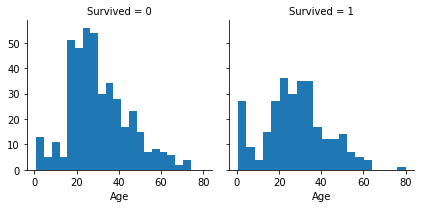

In [11]:
### Numercial features ###
def correlating_numerical_features(data, feature):
    g = sns.FacetGrid(data, col='Survived')
    g.map(plt.hist, feature, bins=20)
    plt.show()
correlating_numerical_features(train, 'Age')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


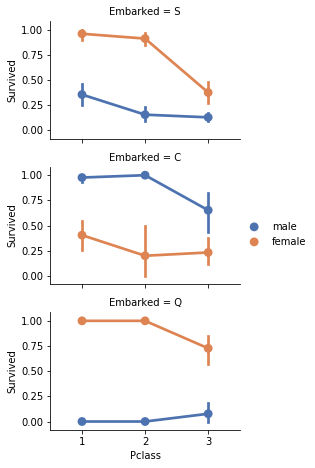

In [12]:
def correlating_categorical_features(data, feature_A, feature_B, feature_C):
    grid = sns.FacetGrid(data, row=feature_A, height=2.2, aspect=1.6)
    grid.map(sns.pointplot, feature_B, 'Survived', feature_C, palette='deep')
    grid.add_legend()
    plt.show()
correlating_categorical_features(train, 'Embarked', 'Pclass', 'Sex')


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


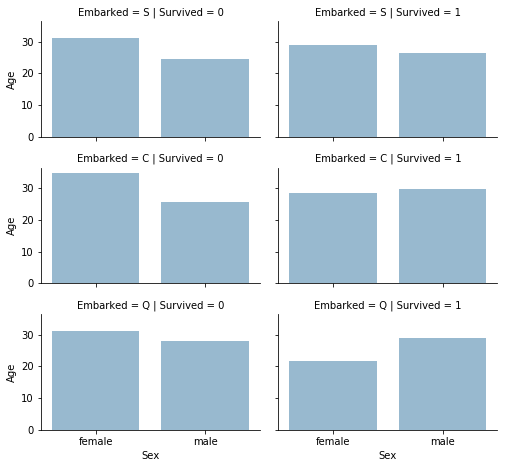

In [13]:
def correlating_categorical_and_numerical_features(data, feature_A, feature_B, feature_C):
    grid = sns.FacetGrid(data, row=feature_A, col='Survived', height=2.2, aspect=1.6)
    grid.map(sns.barplot, feature_B, feature_C, alpha=.5, ci=None)
    grid.add_legend()
    plt.show()
# correlating_categorical_and_numerical_features(train, 'Embarked', 'Sex', 'Fare')
correlating_categorical_and_numerical_features(train, 'Embarked', 'Sex', 'Age')

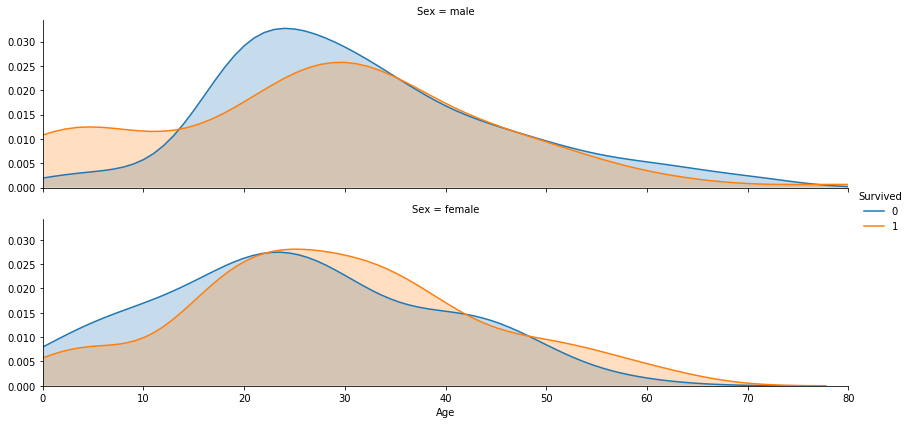

In [14]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.show()
plot_distribution( train , var = 'Age' , target = 'Survived' , row = 'Sex' )

## <font color=blue>2. Preprocessing </font> 

In [15]:
survived = train['Survived']
train.drop('Survived', axis=1, inplace=True)
test = pd.read_csv("./datasets/test.csv")
data = train.append(test , ignore_index = True)
data = data.sort_values('Name')

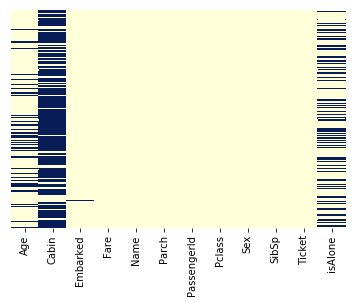

               Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1308.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    33.295479     0.385027   655.000000     2.294882   
std      14.413493    51.758668     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.895800     0.000000   328.000000     2.000000   
50%      28.000000    14.454200     0.000000   655.000000     3.000000   
75%      39.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

             SibSp     isAlone  
count  1309.000000  891.000000  
mean      0.498854    0.180696  
std       1.041658    0.384982  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    0.000000  
max       8.000000    1.000000  
              Cabin Embarked        

In [16]:
passenger_id = data['PassengerId']
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')
plt.show()

print(data.describe())
print(data.describe(include=['O']))
print(data.info())

1 nan in Fare <br>
Embarked has two nans <br>
Cabin and Age have many nans

In [17]:
sex = pd.get_dummies(data['Sex'], drop_first=True)

embarked = pd.get_dummies(data['Embarked'], drop_first=False, prefix='Embark') #fills nan with 0 0 0
embarked.drop('Embark_C', axis=1, inplace=True)
# embarked.drop('Embark_Q', axis=1, inplace=True)


pclass = pd.get_dummies(data['Pclass'], drop_first=False, prefix='class')
pclass.drop('class_2', axis=1, inplace=True)
pclass.drop('class_1', axis=1, inplace=True)

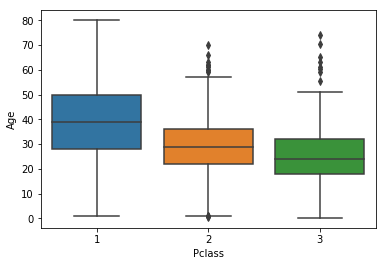

In [18]:
sns.boxplot(x='Pclass', y='Age', data=data)
plt.show() 
#### 39 for pclass=1 & 29 pclass=2  & 24 pclass=3

In [19]:
def age_handler(cols):
        Age=cols[0]
        Pclass=cols[1]
        
        if pd.isnull(Age):
            if Pclass==1:
                return 39
            elif Pclass==2:
                return 29
            else:
                return 24
        else:
            return Age

    
age = data[['Age', 'Pclass']].apply(age_handler, axis=1)

bins = (0, 20, 28, 38, 80)   #LR coefficient = -0.29
group_names = [1, 2, 3, 4]
age = pd.cut(age, bins, labels=group_names)

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64


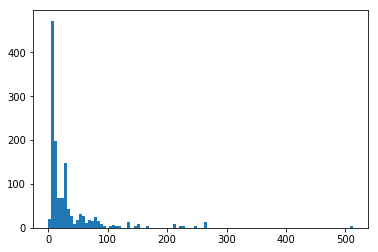

In [20]:
fare = data['Fare'].fillna( data.Fare.mean() )
print(data.Fare.describe())
plt.hist(fare, bins=100)
plt.show()
bins = (-1, 12, 31, 1000)   #LR Coefficient = -0.16
group_names = [0, 1, 2]
fare = pd.cut(fare, bins, labels=group_names)

In [21]:
name = data['Name']
name = name.map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
name = name.replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
name = name.replace(['Mme', 'Mrs', 'Mlle', 'Ms', 'Miss'], 'Female')
name = pd.get_dummies(name, drop_first=False)
name.drop('Master', axis=1, inplace=True)

In [22]:

ticket = data.Ticket
def ticket_handler(ticket):
        ticket = ticket.replace( '.' , '' )
        ticket = ticket.replace( '/' , '' )
        ticket = ticket.split()
        ticket = map( lambda t : t.strip() , ticket )
        ticket = list(filter( lambda t : not t.isdigit() , ticket ))
        if len( ticket ) > 0:
            return (ticket[0])
        else: 
            return 'XX'
ticket = ticket.map( ticket_handler )
ticket = ticket.replace(['SWPP', 'SC'], 'AAA')
ticket = ticket.replace('FCC', 'BBB')
ticket = ticket.replace(['SCAH', 'PP', 'PC'], 'CCC')
ticket = ticket.replace(['CA', 'WEP'], 'DDD')
ticket = ticket.replace('LINE', 'EEE')
ticket = ticket.replace(['SOC', 'SOTONOQ'], 'FFF')
ticket = ticket.replace(['WC', 'A5'], 'GGG')
ticket = ticket.replace(['AS', 'CASOTON', 'SP', 'SOTONO2', 'SCA4', 'SOPP', 'SOP', 'FC', 'Fa', 'SCOW', 'A4'], 'HHH')
ticket = pd.get_dummies(ticket, drop_first=False)
ticket.drop(['PPP', 'STONO', 'STONO2', 'SCParis', 'SCPARIS', 'XX'], axis=1, inplace=True)
ticket.drop(['A', 'AQ3', 'AQ4', 'C', 'LP', 'SCA3', 'STONOQ'], axis=1, inplace=True)


In [23]:
cabin = data.Cabin
cabin = cabin.fillna( 'Without Cabin' )
cabin = cabin.map( lambda c : c[0] )
cabin = cabin.replace(['A','C','F','G','T'], 'drop')
cabin = pd.get_dummies(cabin, drop_first=False)
cabin.drop('drop', axis=1, inplace=True)

In [24]:
siblings = data.SibSp
parents = data.Parch
size = siblings + parents

Fare_Per_Person = (data['Fare'].fillna(data.Fare.mean()))/ (size + 1)
Age_class = data[['Age', 'Pclass']].apply(age_handler, axis=1) * data['Pclass']

isAlone = size.map( lambda s : 'Alone' if s == 1 else 'Not Alone' )
isAlone = pd.get_dummies(isAlone, drop_first=True)

grouping families!

In [26]:
families = pd.DataFrame()
families['Sex'] = data['Sex']
families['PassengerId'] = data['PassengerId']
families['Name'] = data['Name'].map( lambda nam: nam.split( ',' )[0])
families['Survived'] = survived
families['Survived'] = families['Survived'].fillna(-1)
families['Ticket'] = data['Ticket']
families['male_alive'] = 0
families['male_dead'] = 0
families['female_dead'] = 0
families['female_alive'] = 0



for grp, grp_df in families.groupby(['Name','Ticket']):
    if (len(grp_df) != 1): # a family
        male_alive = 0
        male_dead = 0
        female_dead = 0
        female_alive = 0
        for ind, row in grp_df.iterrows():
            if row['Survived']==1 and row['Sex']=='male':
                male_alive=1
            elif row['Survived']==0 and row['Sex']=='male':
                male_dead=1
            elif row['Survived']==1 and row['Sex']=='female':
                female_alive=1
            elif row['Survived']==0 and row['Sex']=='female':
                female_dead=1
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            if row['Sex']=='male':
                families.loc[families['PassengerId'] == passID, 'male_alive'] = male_alive
                families.loc[families['PassengerId'] == passID, 'male_dead'] = male_dead
                families.loc[families['PassengerId'] == passID, 'female_dead'] = female_dead
            else:
                families.loc[families['PassengerId'] == passID, 'male_alive'] = male_alive
                families.loc[families['PassengerId'] == passID, 'female_dead'] = female_dead
                families.loc[families['PassengerId'] == passID, 'female_alive'] = female_alive



In [27]:
z = pd.DataFrame()
z['E'] = data['Embarked']
z['S'] = data['Sex']
z = pd.get_dummies(z, drop_first=False)
z['new'] = z['E_C']*z['S_male'] + z['E_S']*z['S_female'] + z['E_Q']*z['S_female']
my_feature = pd.DataFrame()
my_feature['feature'] = z['new']
my_feature = pd.get_dummies(my_feature['feature'], drop_first=False)


In [28]:
sexx = data['Sex']
sexx = sexx.replace('male', 1)
sexx = sexx.replace('female', -1)
age_sex = age.astype(np.int8) * sexx
age_sex = pd.get_dummies(age_sex, drop_first=False)
age_sex.drop([-4,-3,-2,-1,2,3,4], axis=1, inplace=True)

In [29]:
processed_data = pd.concat([sex,pclass,fare,name,ticket,cabin,my_feature,age_sex], axis=1)
processed_data['age'] = age
processed_data['isAlone'] = isAlone
processed_data['id'] = passenger_id

In [30]:
Fare_Per_Person = normalizer(Fare_Per_Person)
Age_class = normalizer(Age_class)
processed_data['Age_class'] = Age_class

In [31]:
processed_data['f_d'] = families['female_dead'] 
processed_data['f_a'] = families['female_alive'] 

processed_data = processed_data.sort_values('id')
processed_data.drop('id', axis=1, inplace=True)

## <font color=blue>3. Training </font> 

In [33]:
y_train = pd.read_csv("./datasets/train.csv")['Survived']

x_train = processed_data[0:891]
x_test = processed_data[891:]


n_neighbors = [6]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,10))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")

gd.fit( x_train , y_train )
print (gd.score( x_train , y_train ))

y_pred = gd.predict(x_test)
y_test = pd.read_csv("./datasets/labeled_test_set.csv")
y_test = np.array(y_test.loc[:,'Survived']) 
print (gd.score( x_test , y_test ))

g = np.subtract(y_test, y_pred)
g = abs(g)
m = 418
print("Test Accuracy = " + str(1 - (np.sum(g)) / m))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9446867776606056
0.8237828627069133
Test Accuracy = 0.8157894736842105


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


In [34]:
temp = pd.DataFrame(pd.read_csv("./datasets/test.csv")['PassengerId'])
temp['Survived'] = y_pred
temp.to_csv("./datasets/submission.csv", index = False)